In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
import pickle

Using TensorFlow backend.


In [6]:
# convert raw .dat file to  csv using curate_db.py
# file has to exist in db/udb_1yr.dat
# !python curate_db.py 

In [7]:
all_dat = pd.read_csv('./curated.csv', index_col=0)

# sift out pwrs
all_dat = all_dat.loc[all_dat['reactor_type'] == 'PWR']  
all_dat = sklearn.utils.shuffle(all_dat)
# only get assemblies with enrichment bigger than 1.5 and bunrup higher than 10,000
all_dat = all_dat.loc[(all_dat['init_enr'] > 1.5) & (all_dat['bu'] > 10000)]

# separate training and testing set
row_num = all_dat.shape[0]
cutoff = int(row_num * 0.6)
train_dat = all_dat.iloc[:cutoff, :]
test_dat = all_dat.iloc[cutoff:, :]


In [9]:
# get all the isotopes, sorted by A
def get_name(f):
    z = ''
    for i in f:
        if i.isalpha():
            z += i
    return z

def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)

iso_list = list(train_dat)[5:]
print(iso_list)
# set the isotopes to categories:
fp = []
bred_fissile = []
u235 = []
nottru = []
tru = []

for iso in iso_list:
    if iso == 'other':
        continue
    if iso == 'u-235':
        u235.append(iso)
    elif iso in ['pu-239', 'u-233']:
        bred_fissile.append(iso)
    elif get_a(iso) < 200:
        fp.append(iso)
    elif get_name(iso) in ['np', 'pu', 'am', 'cm']:
        tru.append(iso)
    else:
        nottru.append(iso)

category = {'u235': u235,
            'bred_fissile': bred_fissile,
            'fp': fp,
            'tru': tru,
            'nottru': nottru}

print(category)

['zr-95', 'zr-93', 'ra-226', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'pu-238', 'pu-239', 'np-237', 'nb-95', 'pa-231', 'pd-107', 'pm-147', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cm-248', 'cs-134', 'cs-135', 'cm-245', 'cm-244', 'cm-246', 'cm-247', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'am-241', 'am-242m', 'am-243', 'cf-251', 'cf-249', 'ag-108m', 'ag-110m', 'ac-227', 'cm-243', 'cm-242', 'c-14', 'ce-144', 'u-234', 'u-235', 'u-236', 'y-90', 'u-238', 'th-229', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126', 'th-232', 'th-230', 'u-232', 'u-233', 'other']
{'u235': ['u-235'], 'bred_fissile': ['pu-239', 'u-233'], 'fp': ['zr-95', 'zr-93', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'nb-95', 'pd-107', 'pm-147', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cs-134', 'cs-135', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'ag-108m', 'ag-110m', 'c-14', 'ce-144', 'y-90', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126'], 'tru': ['pu-238', 'np-237', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 

## Visualize Data

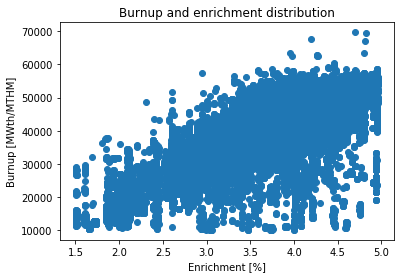

In [10]:
# visualize 
plt.scatter(all_dat['init_enr'], all_dat['bu'])
plt.xlabel('Enrichment [%]')
plt.ylabel('Burnup [MWth/MTHM]')
plt.title('Burnup and enrichment distribution')
plt.show()




u235
u-235


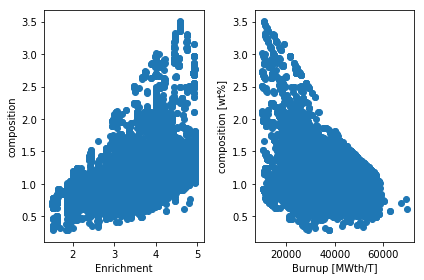

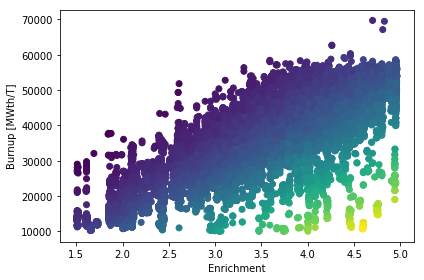




bred_fissile
pu-239


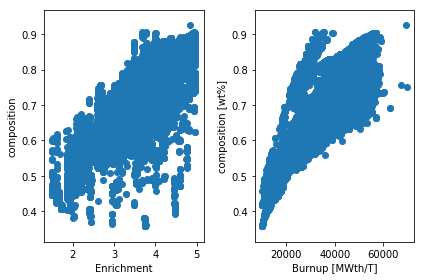

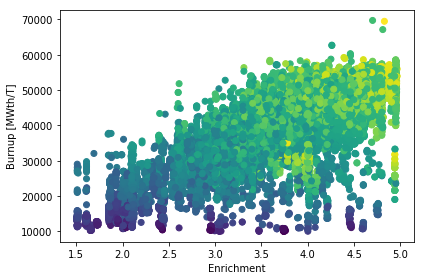

u-233


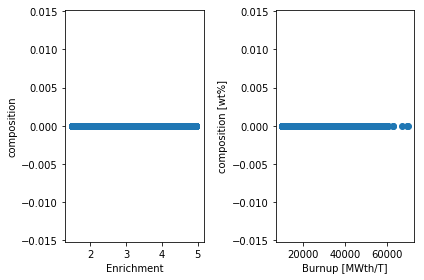

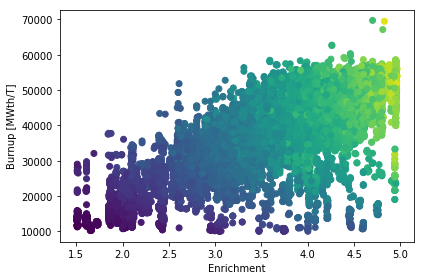




fp
zr-95


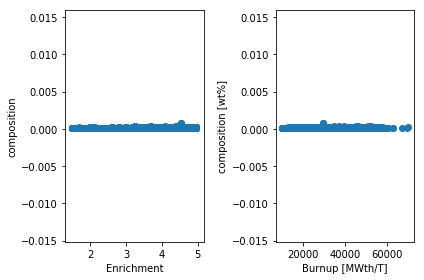

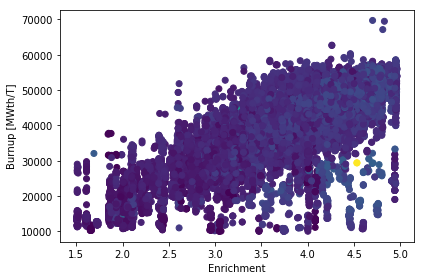

zr-93


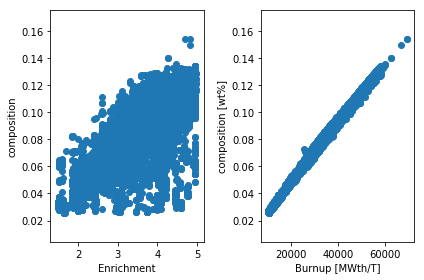

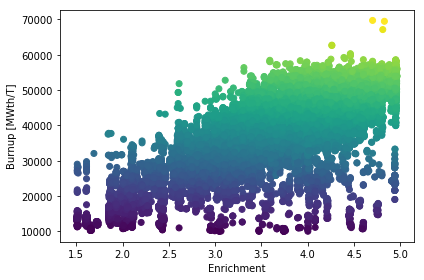

ru-103


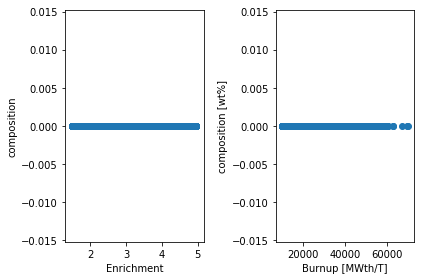

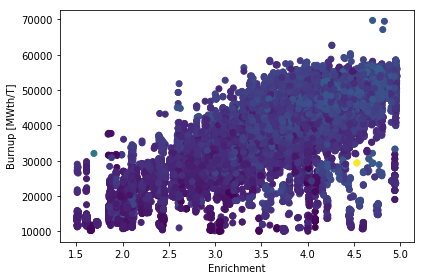

ru-106


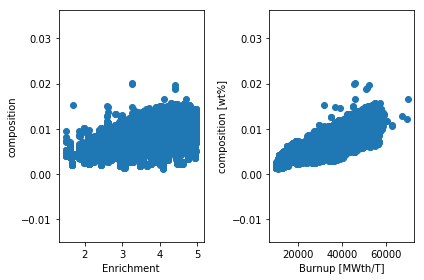

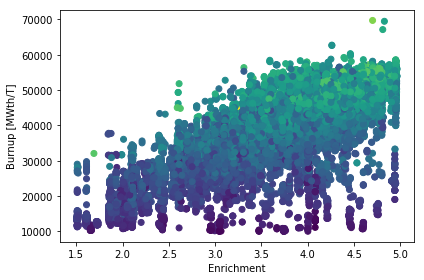

sb-124


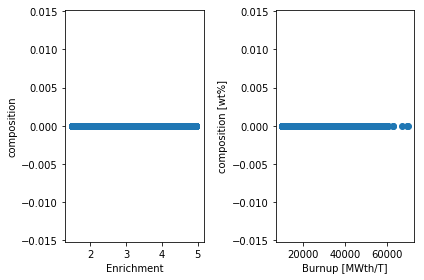

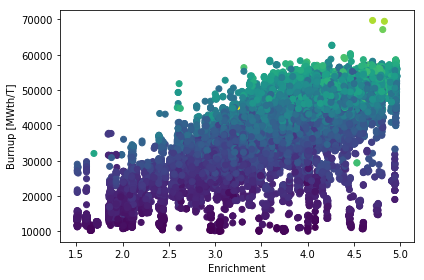

sb-125


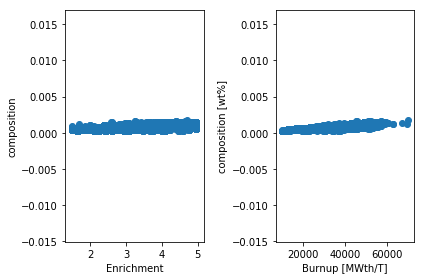

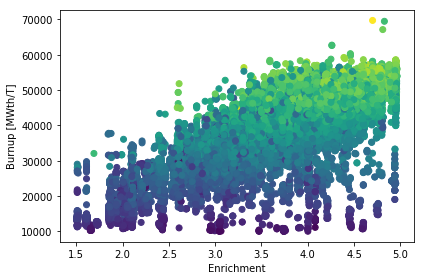

nb-95


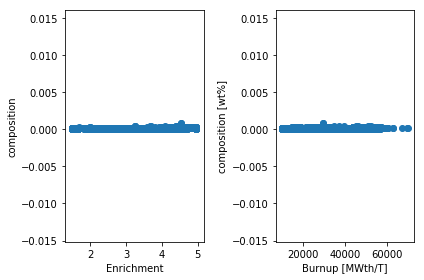

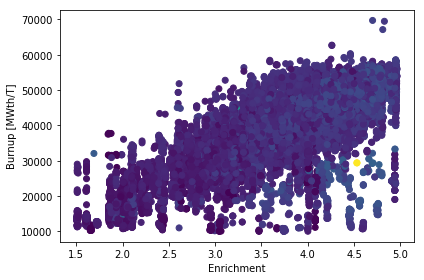

pd-107


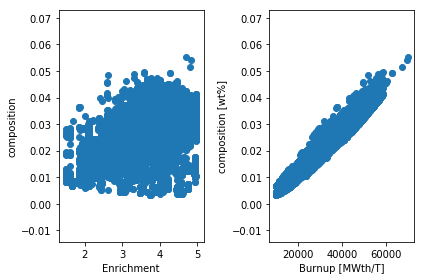

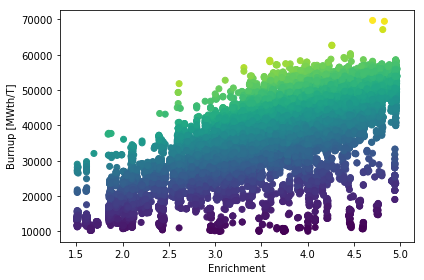

pm-147


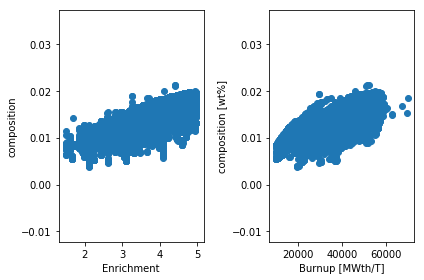

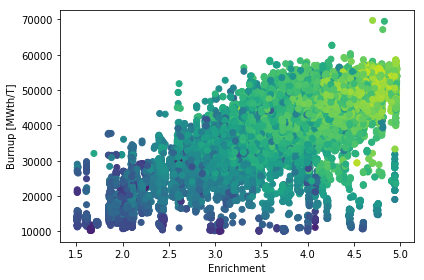

i-129


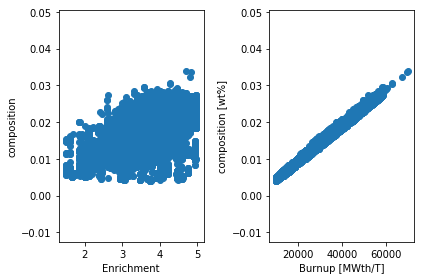

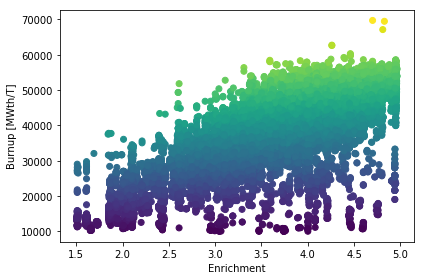

h-3


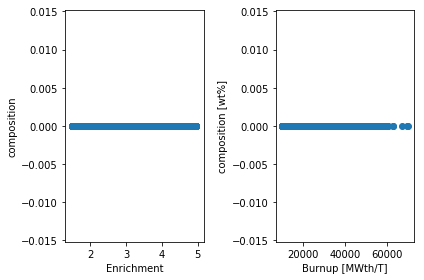

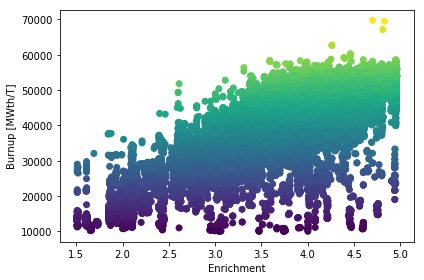

kr-85


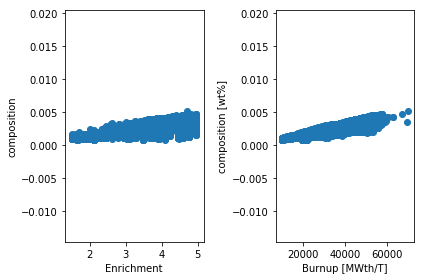

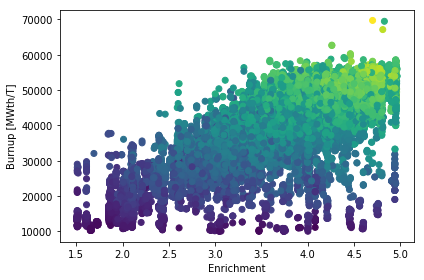

nb-94


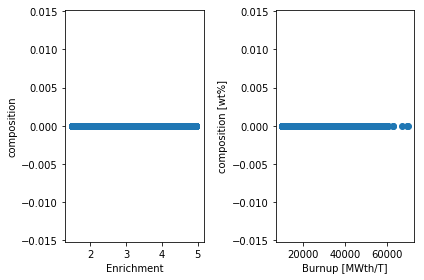

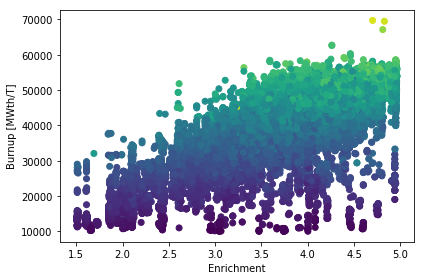

cs-134


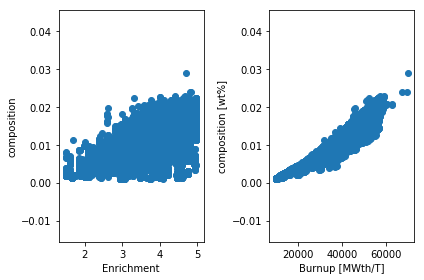

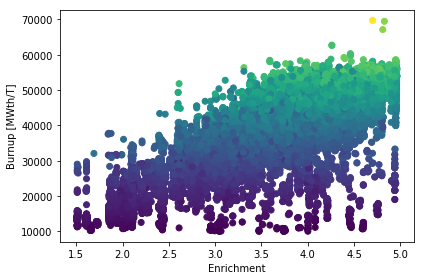

cs-135


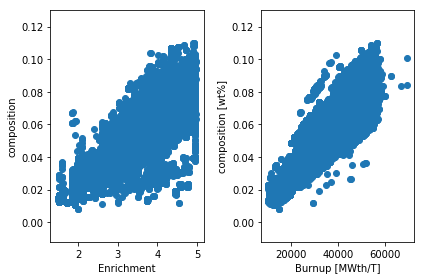

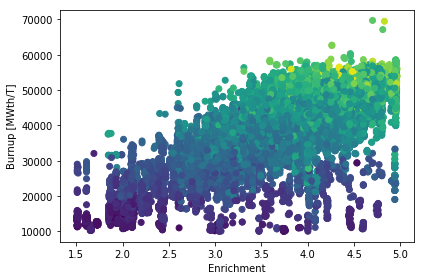

eu-152


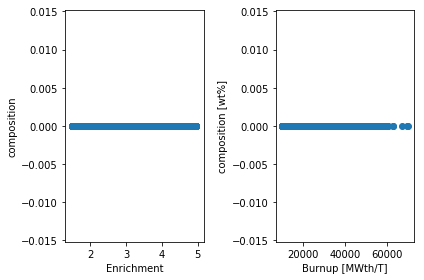

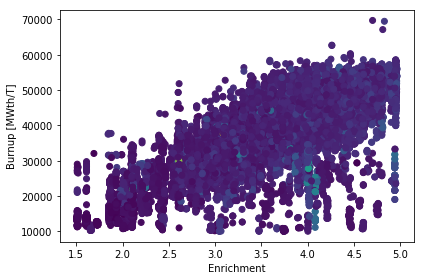

cs-137


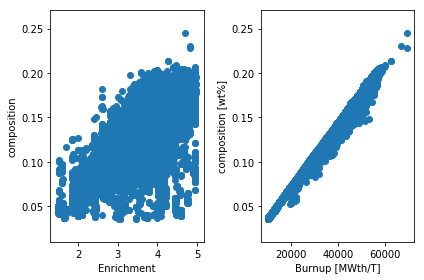

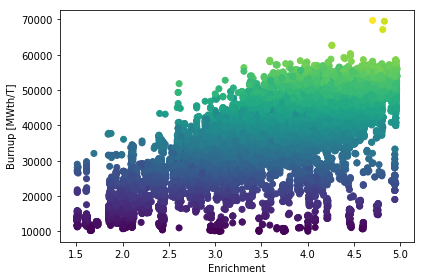

eu-154


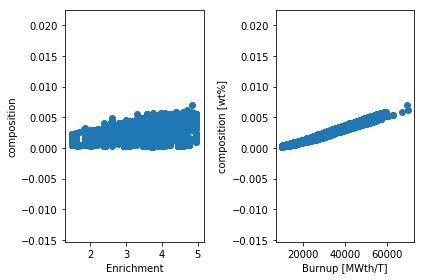

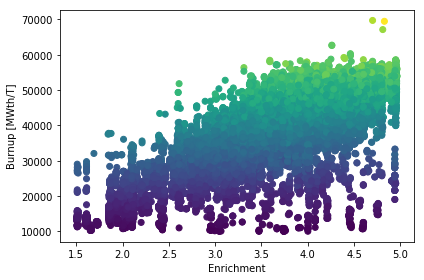

eu-155


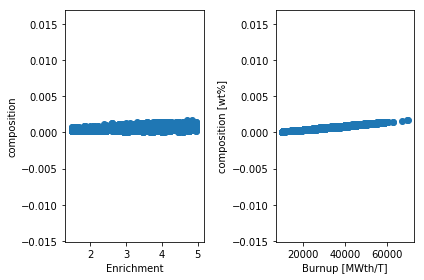

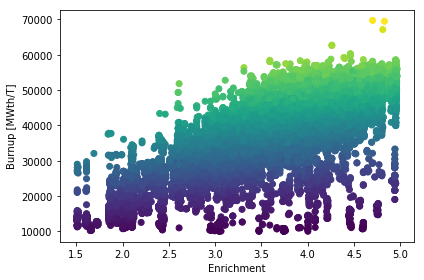

ag-108m


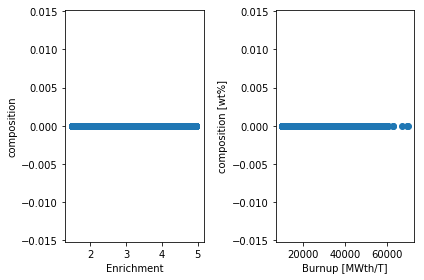

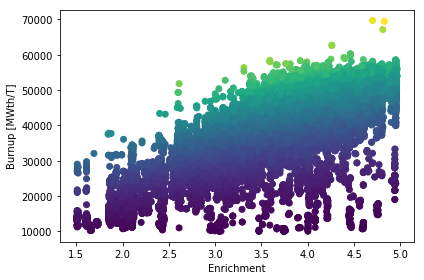

ag-110m


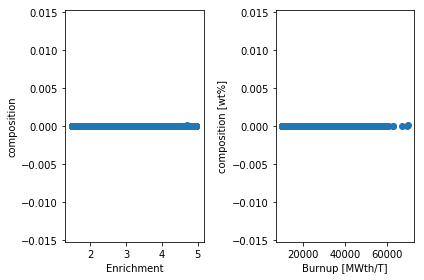

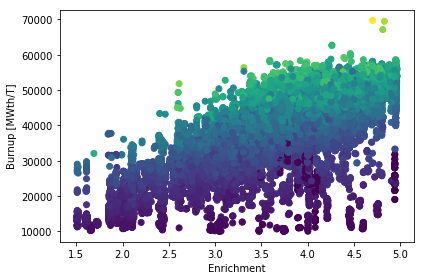

c-14


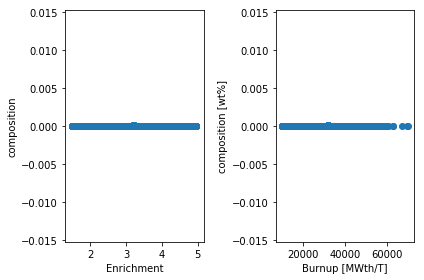

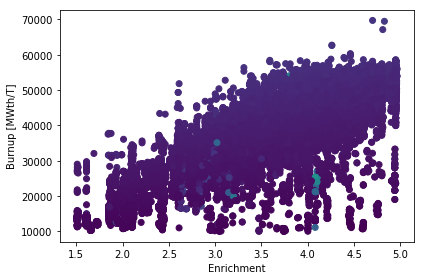

ce-144


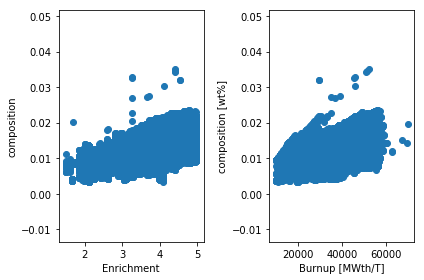

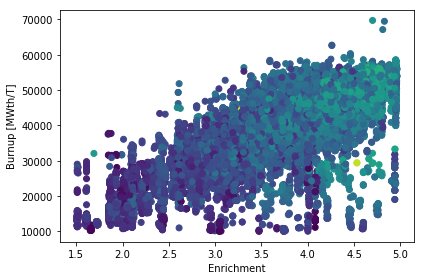

y-90


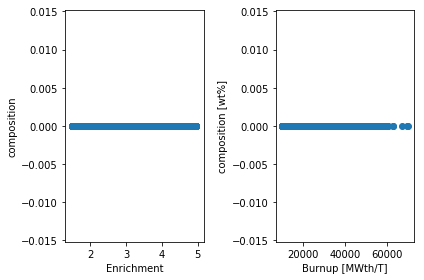

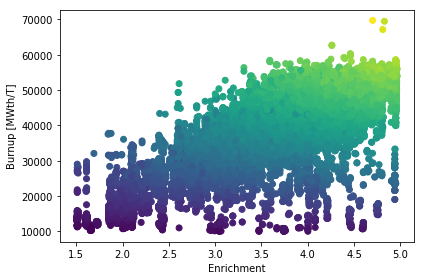

tc-99


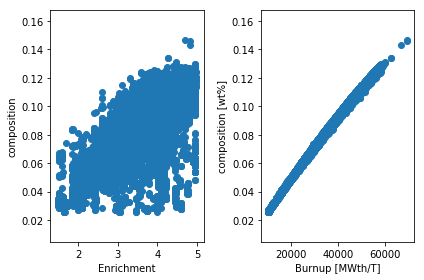

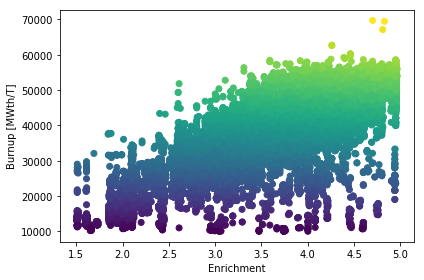

sm-151


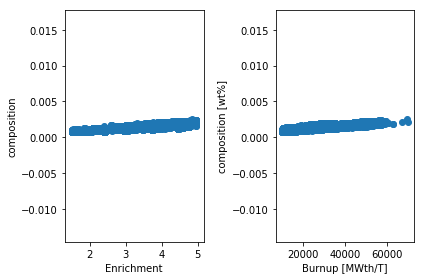

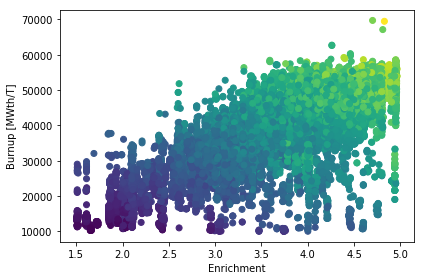

se-79


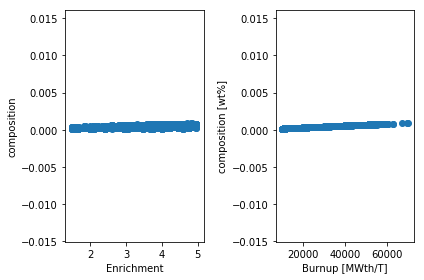

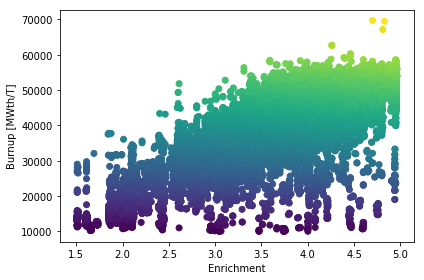

sr-90


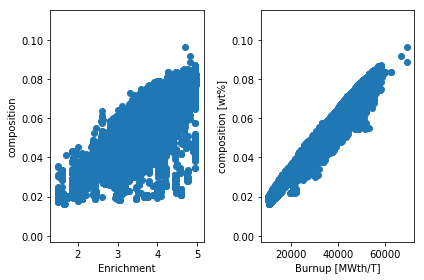

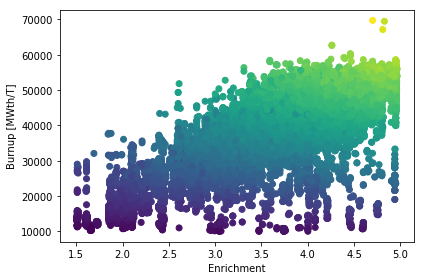

sn-126


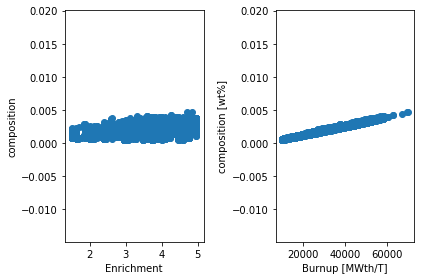

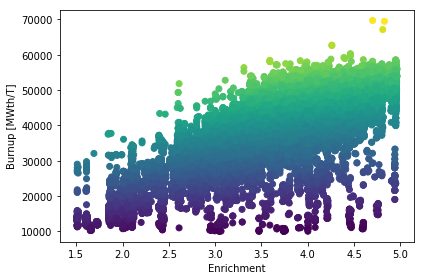




tru
pu-238


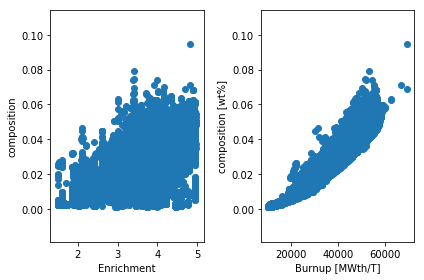

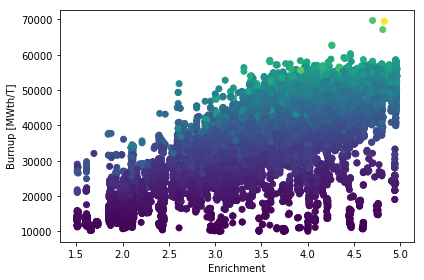

np-237


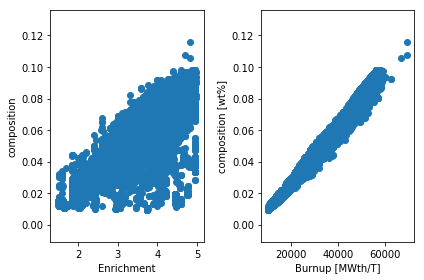

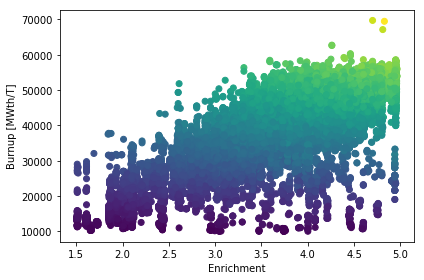

pu-240


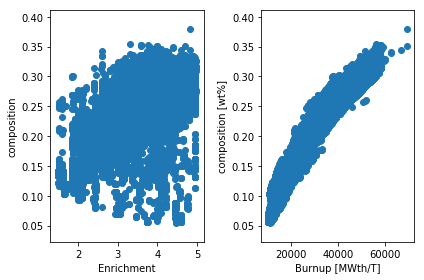

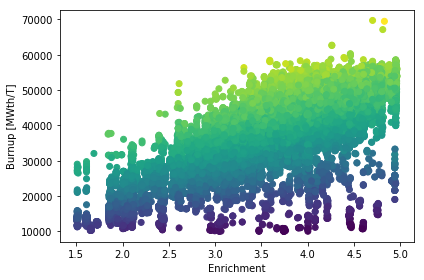

pu-241


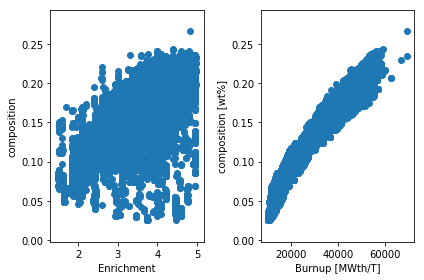

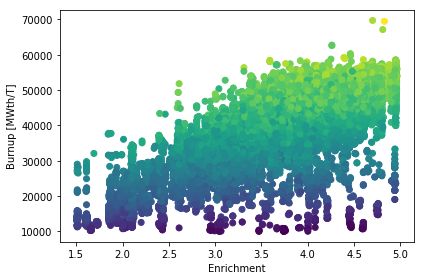

pu-244


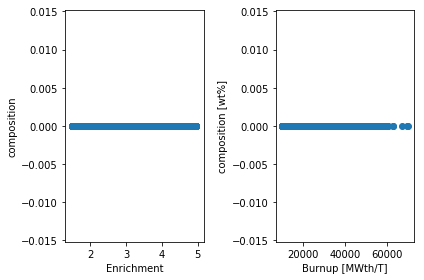

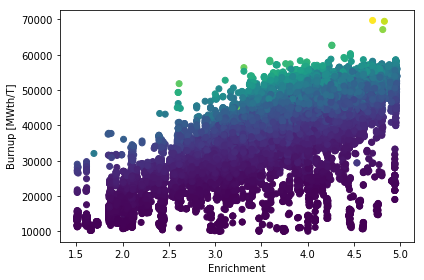

pu-242


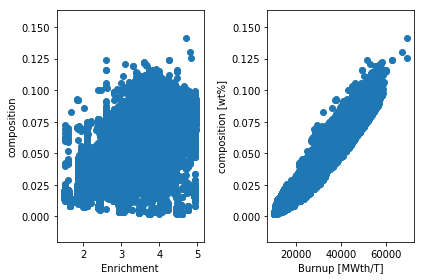

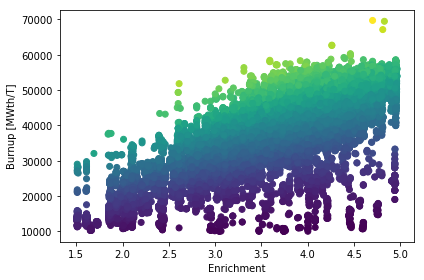

cm-248


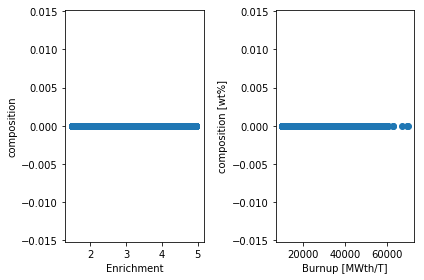

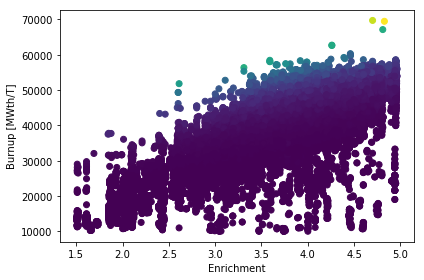

cm-245


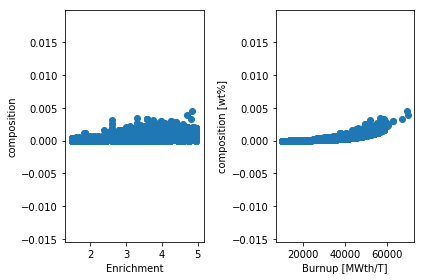

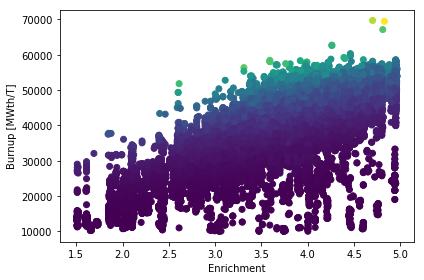

cm-244


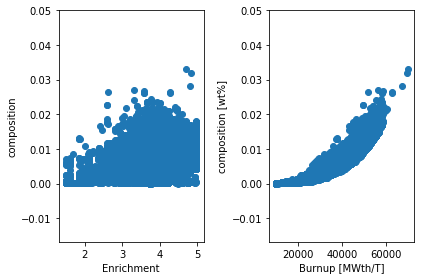

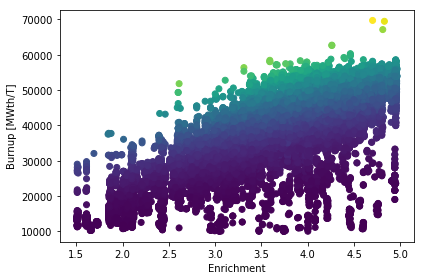

cm-246


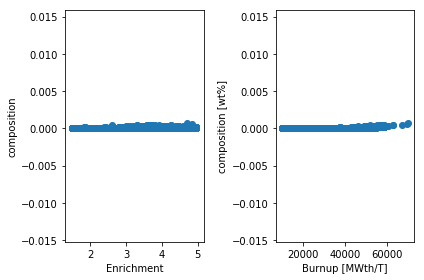

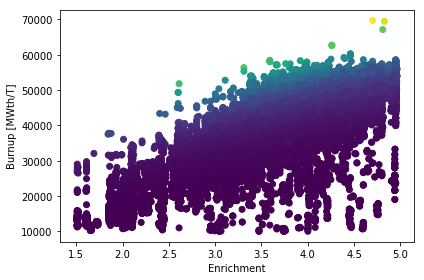

cm-247


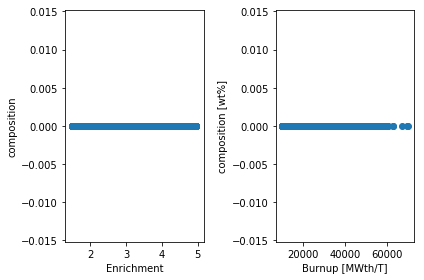

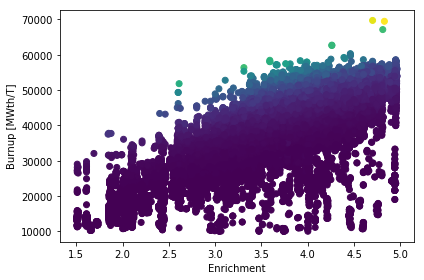

am-241


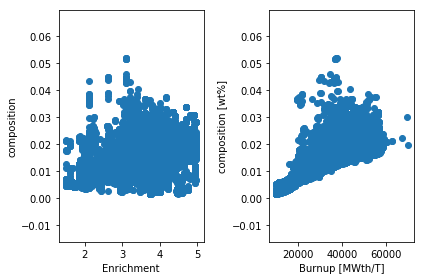

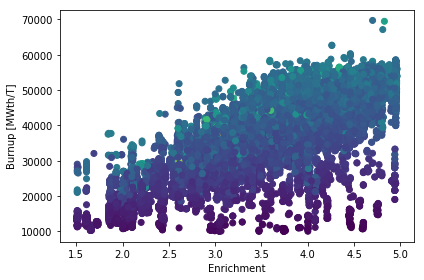

am-243


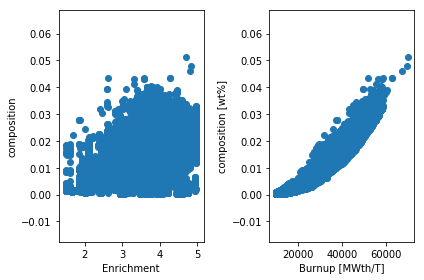

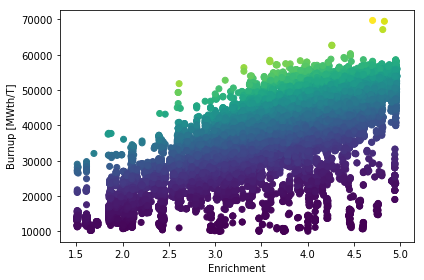

cm-243


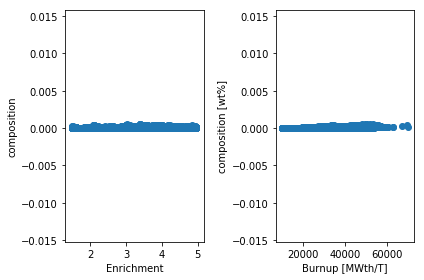

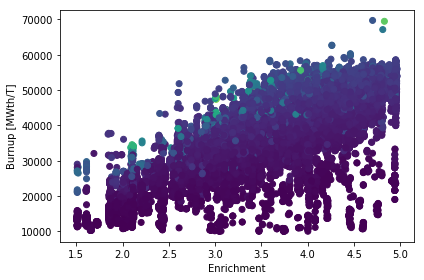

cm-242


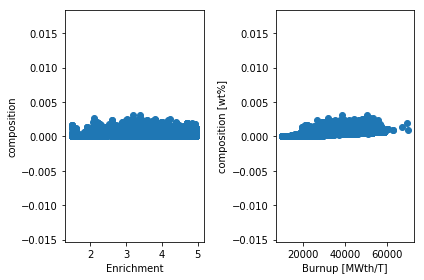

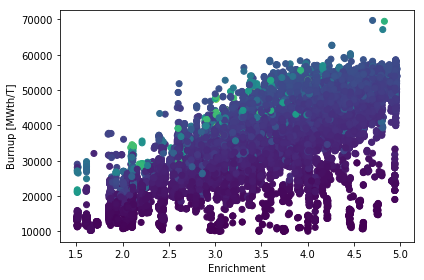




nottru
ra-226


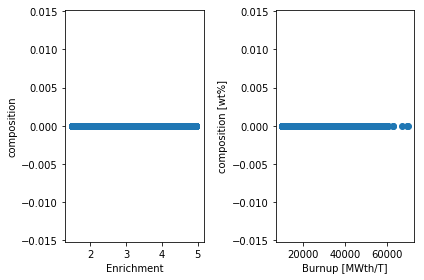

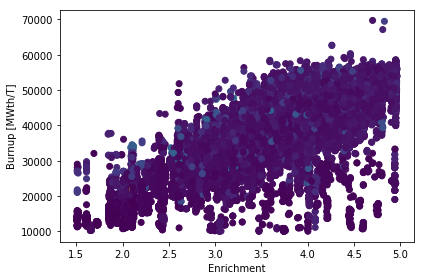

pa-231


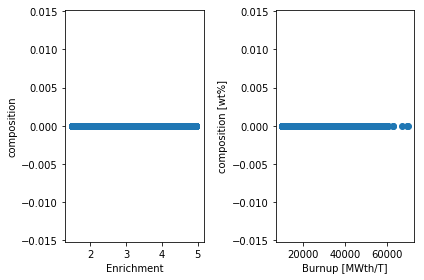

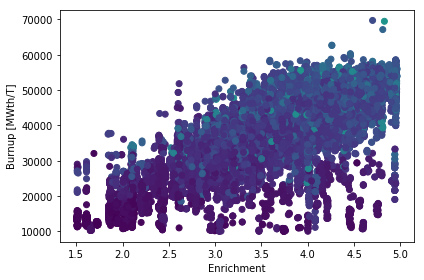

am-242m


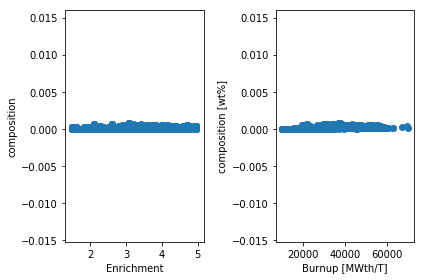

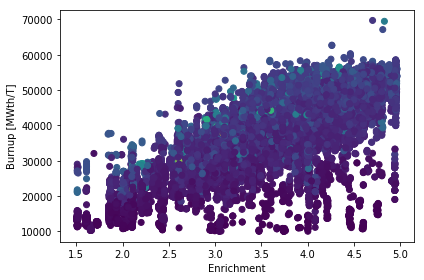

cf-251


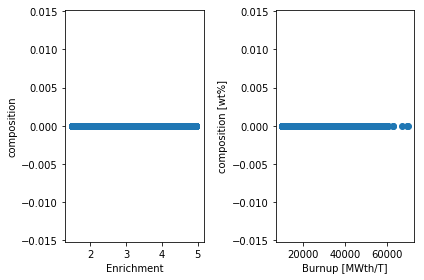

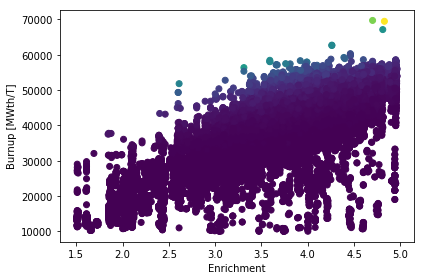

cf-249


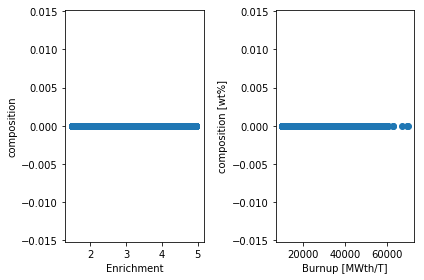

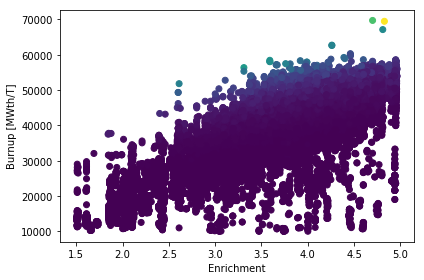

ac-227


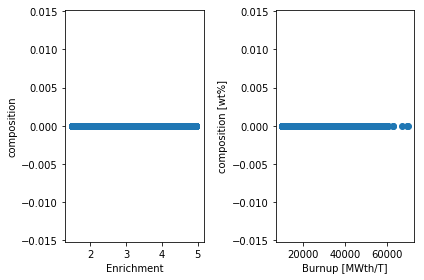

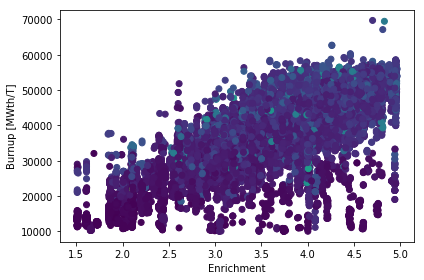

u-234


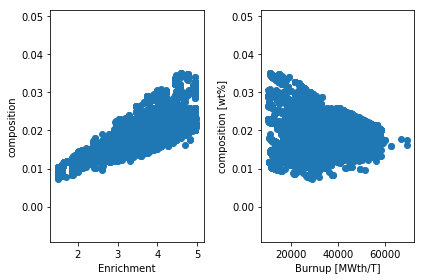

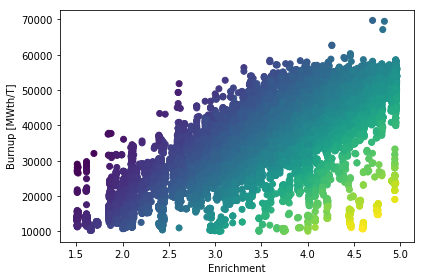

u-236


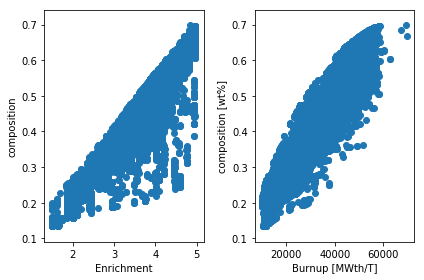

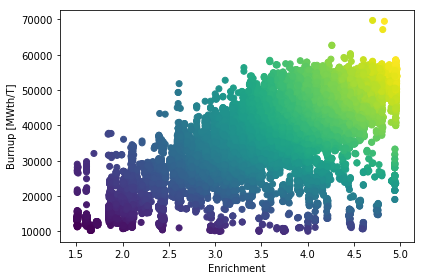

u-238


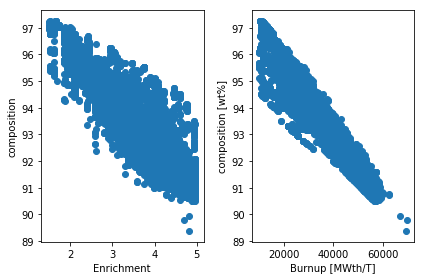

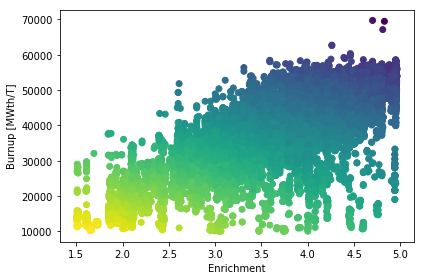

th-229


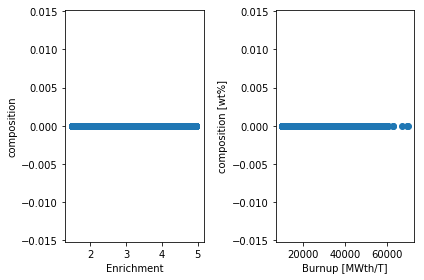

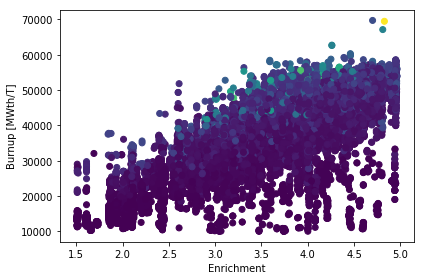

th-232


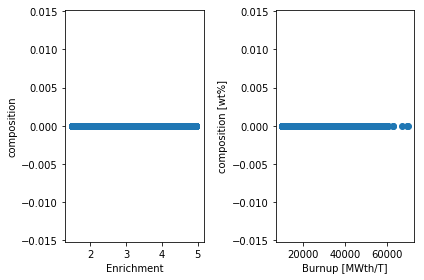

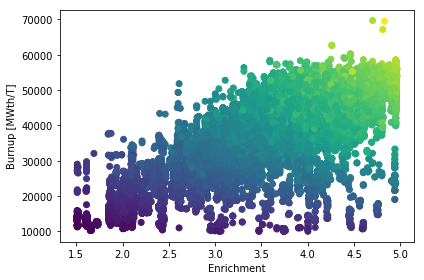

th-230


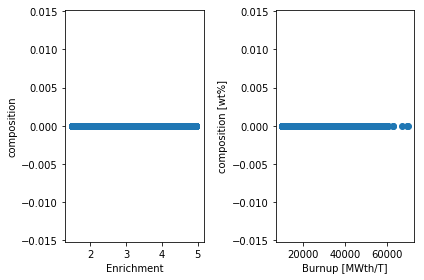

In [ ]:
## visualize how each isotope is correlated with burnup / enrichment
def plot_side_by_side(x1, y1, x2, y2, xlabel1, xlabel2, iso_name):
    
    plt.subplot(1, 2, 1)
    plt.scatter(x1, y1)
    plt.xlabel(xlabel1)
    plt.ylabel('composition')

    plt.subplot(1, 2, 2)
    plt.scatter(x2, y2)
    plt.xlabel(xlabel2)
    plt.ylabel('composition [wt%]')
    
    plt.tight_layout()
    plt.savefig('images/isos/' + iso_name + '_sub', format='png')
    plt.show()
    plt.close()

    plt.scatter(x1,x2, c=y1)
    plt.xlabel(xlabel1)
    plt.ylabel(xlabel2)
    plt.tight_layout()
    plt.savefig('images/isos/' + iso_name + '_tot', format='png')
    plt.show()
    plt.close()
    
    
# show two plots (subfigs) with x = [burnup, enrichment] and y = isotope composition
x1 = list(train_dat['init_enr'])
x2 = list(train_dat['bu'])
for key, val in category.items():
    print('\n\n')
    print(key)
    for iso in val:
        y = list(train_dat[iso])
        print(iso)
        plot_side_by_side(x1, y, x2, y, 'Enrichment', 'Burnup [MWth/T]', iso)

# see cf-251 distribution
print(max(all_dat['cf-251']))
print(min(all_dat['cf-251']))
fig = plt.figure()
ax = plt.gca()
ax.scatter(list(all_dat['bu']), all_dat['cf-251'])
ax.set_yscale('log')
plt.ylim(1e-19, 1e-9)
plt.show()
plt.close()